# Lab 3
## Task 3: Compute Homography from Points (40 pts)

We are given points correspondences from two images. We want to compute the homography. As an example we will use the same two images as in previous tasks.

In [2]:
from IPython.display import Image
import cv2
import numpy as np

train_img = cv2.imread('images/green.png')
poster_img = cv2.imread('images/poster.png')
(ph,pw,pc) = poster_img.shape

poster_p = np.array([[0, 0, 1], [0, pw, 1], [ph, pw, 1], [ph, 0, 1]])
train_p = np.array([[170, 95, 1], [171,238, 1], [233,235, 1], [239,94, 1]])

Let consider the pair of corresponding points. We want to find matrix $H$:

$$
\begin{bmatrix}
  H_{11} & H_{12} & H_{13} \\
  H_{21} & H_{22} & H_{23} \\
  H_{31} & H_{32} & H_{33} \\
\end{bmatrix}
\begin{bmatrix}
  x_1 \\
  y_1 \\
  z_1 \\
\end{bmatrix}
=
\begin{bmatrix}
  x_2 \\
  y_2 \\
  z_2 \\
\end{bmatrix}
$$

let $x' = x/z$ and $y' = y/z$, then:

$$ x_2' = \frac{H_{11}x_1+H_{12}y_1+H_{13}z_1}{H_{31}x_1+H_{32}y_1+H_{33}z_1}$$

$$ y_2' = \frac{H_{21}x_1+H_{22}y_1+H_{23}z_1}{H_{31}x_1+H_{32}y_1+H_{33}z_1}$$

We can now rearrange those two equation into:

$$ a_x^T\mathbf{h} = 0$$
$$ a_y^T\mathbf{h} = 0$$

where

$$ h = (H_{11},H_{12},H_{13},H_{21},H_{22},H_{23},H_{31},H_{32},H_{33})^T $$

$$ a_x = (-x_1,-y_1,-z_1,0,0,0,x_2'x_1,x_2'y_1,x_2'z_1)^T $$
$$ a_y = (0,0,0,-x_1,-y_1,-z_1,y_2'x_1,y_2'y_1,y_2'z_1)^T $$

Finally given a set of corresponding points, we can form the following linear system of equations,

$$
A\mathbf{h} = 0
$$

where

$$
A= \begin{pmatrix}
  a_{x_1}^T \\
  a_{y_1}^T \\
  \vdots \\
  a_{x_N}^T \\
  a_{y_N}^T \\
\end{pmatrix}
$$

We solve it using Singular Value Decomposition (SVD). From the SVD we take the "right singular vector" (a column from V) which corresponds to the smallest singular value.

In [3]:
def find_homography(p1, p2):
    A = np.zeros((8, 9), np.float32)
    for i in range(0,4): 
        A[2*i] 	= [-p1[i,0],-p1[i,1],-p1[i,2],0,0,0,(p2[i,0]/p2[i,2])*p1[i,0],(p2[i,0]/p2[i,2])*p1[i,1],(p2[i,0]/p2[i,2])*p1[i,2]]
        A[2*i+1]= [0,0,0,-p1[i,0],-p1[i,1],-p1[i,2],(p2[i,1]/p2[i,2])*p1[i,0],(p2[i,1]/p2[i,2])*p1[i,1],(p2[i,1]/p2[i,2])*p1[i,2]]

    U, s, V = np.linalg.svd(A, full_matrices=True)
    H = V[8,:]
    return H.reshape((3,3))

For testing our homography we need code from previous tasks

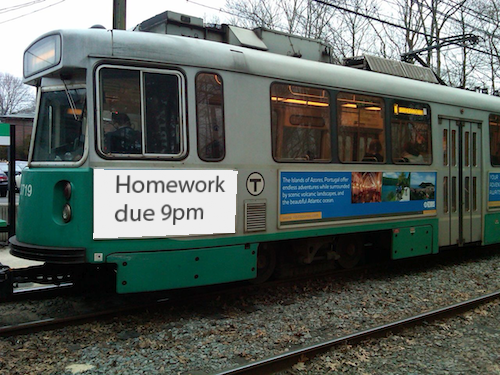

In [4]:
from homography import apply_homography_bi


H = find_homography(train_p,poster_p)

output_img = apply_homography_bi(train_img, poster_img, H)
output_path = 'output/trainBI_myHomography.png'
cv2.imwrite(output_path,output_img)
Image(output_path)